# League of Legends Win Chance Prediction
### ML model to predict the outcome of a League of Legends match based on champion selection

## Introduction
League of Legends, often abbreviated as LoL, is a popular online multiplayer video game. It's a competitive 5 versus 5 team-based game in which players control unique champions with special abilities and work together to defeat the opposing team. The main objective is to destroy the enemy team's Nexus, a structure in their base, while defending your own. It combines elements of strategy, teamwork, and individual skill and is known for its strategic depth and fast-paced action. League of Legends is played by millions of players worldwide and has a thriving esports scene with professional leagues and tournaments.

In the competitive environment of League of Legends, players are always looking for ways to improve their chances of winning. Since it's a strategy game, one key element affecting a team's success is the mix of champions they pick. Our aim is to create a model that helps players make better decisions about champion selection and team composition by predicting the likelihood of each team winning based on their chosen champions. This also enables the most dedicated players to dodge an unfavorable matchup before the game begins in such a case where the prediction of their chances of winning are looking less than good.

The information about the match is limited to just the champions picked before the game actually begins, so we are going to be using only this information for training our model. 



## Expected Results
- since the are many variables we cant account for, we don't expect to get very high accuracy
- accuracy at least over avg win rate, but maybe between 55 to 60%
- use the trained model to predict outcomes of matches during and after champ select
- use the trained model to find optimal champion during champ select (best win chance)

## Dataset
There are several datasets available online that contain information about the outcome of the game, champions selected, player stats and much more. There is also the official Riot Games API available, which could be used to gather data from the latest version of the game.

For the purpose of this concept, we will be using a dataset from Kaggle. This gives us easy access to a lot of training data, without being limited by the API. While this means that the data is not up to date, it is still a good starting point for our model and useful for evaluating the concept.

The dataset [League of Legends- 1 day's worth of solo queue KR](https://www.kaggle.com/datasets/junhachoi/all-ranked-solo-games-on-kr-server-24-hours/) contains information about all ranked matches on the League of Legends Korean Server during the course of 1 day (GMT 2022/07/02 00:00:00 to 2022/07/03 00:00:00). In total, this amounts to over 250.000 matches. The advantage this dataset has over other datasets is that it is very large and one of the most recent ones available. The data is also from a single day, which means that the game version is the same for all matches. This is important because the game is constantly being updated and the balance of champions changes with every patch. This means that the data from older patches is not as useful for training our model.

### Data cleaning
We will try to clean and improve the dataset by removing some outliers that could negatively impact training. The data cleaning will only be applied to the training data, so we can determine if it had a positive impact. We will also compare the cleaned data with uncleaned data to decide which method is better.

The dataset contains multiple values that could be helpful to filter the games. In general, we want to remove games in which the champion selection had a lower impact than usual. We are doing this by finding games that were already uneven from the beginning, since this could indicate that the players' skill level was further apart than normal or that something else that had nothing to do with the champions effected the game, like a player disconnection or not participating. 

There is a risk that filtering the games in this way will create some form of bias, especially against champions that are stronger in the early stages of the game. We will have to measure how this cleaning effects the performance of our models and adjust the thresholds for filtering games if necessary. 

The keys we are using to filter games are the following:
- gameEndedInEarlySurrender
  - This flag indicates whether one team surrendered early.
- timePlayed
  - We are filtering games that are shorter than 20min, since these games were probably very uneven.
- champLevel
  - We are filtering games were one or more champions are far below the average, indicating that they were not participating.


In [1]:
# if false, preprocessed data will be loaded from disk
# same results, but faster
CONVERT_DATA = False
import numpy as np
train, train_filtered, val, test = None, None, None, None

if CONVERT_DATA:
    # load data used for training
    import data.kr_24h.convert as convert

    # load the data, including stats we dont need
    games_dict = convert.load_raw_csv(file_path="data/kr_24h/kr_soloq_24h/sat df.csv")
    games = list(games_dict.values())

    # shuffle games
    np.random.shuffle(games)

    # split into train, val, test
    train, val, test = convert.split_iterable(games, weights=(90, 5, 5))
    print("train: ", len(train))
    print("val: ", len(val))
    print("test: ", len(test))
    print()

    # convert each match into a list of 10 champions and a 1/0 for win/loss of blue team
    # two copies of train data, one with some matches filtered out
    train, train_filtered = convert.convert_data(train, filter_matches=False), convert.convert_data(train, filter_matches=True)
    val = convert.convert_data(val, filter_matches=False)
    test = convert.convert_data(test, filter_matches=False)

In [2]:
# for some reason, this takes like 20min to run in the notebook, but only 1min directly in python

# to save some time, we saved the data to a file and load it here, but you can also just run the above code if you have time
# the result is the same
import numpy as np
dir = "data/notebook/"


if not CONVERT_DATA:
    # load the data
    train = np.load(dir + "train.npy")
    train_filtered = np.load(dir + "train_filtered.npy")
    val = np.load(dir + "val.npy")
    test = np.load(dir + "test.npy")

    # print lengths
    print("train: ", len(train))
    print("train_filtered: ", len(train_filtered))
    print("val: ", len(val))
    print("test: ", len(test))

train:  233040
train_filtered:  204704
val:  12947
test:  12947


## Data Analysis
Before we can start training our model, we need to do some data analysis to get a better understanding of the data. This will help us decide which features to use and how to process them. It can also help us with evaluating the performance of our models later on.

### Overall Win Rate
The first thing we want to look at is the overall win rate (of the blue side). Since the game is not symmetrical, we can't assume that the win rate is 50%. In fact, during most patches, the blue side (bottom left) has a slightly higher win rate than the red side. This can be explained by several factors, such as the camera angle, the position of the minimap, and the position of the HUD. The blue side also has a slight advantage in champion select, since they get to pick first.

This overall win rate gives us a baseline for our model. If our model is not able to beat this baseline, then it is not very useful. The overall win rate is calculated by dividing the number of wins by the total number of matches.

In [3]:
# calculate overall win rate here

### Champion Win Rate
Next, we want to look at the win rate of each champion. This gives us an idea of how strong each champion is and how likely they are to win. We can also see which champions are the most popular and which ones are the least popular. With this, we can evaluate the performance of our model and see if it is able to predict the outcome of the game better than just picking the most popular champions. If we match champions with high win rates against champions with low win rates, we can also see if our models are able to predict the outcome of the game correctly.

In [4]:
# split into x and y
train_x, train_y = train[:, :-1], train[:, -1]
train_filtered_x, train_filtered_y = train_filtered[:, :-1], train_filtered[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# convert y to float and to correct shape
def conv_y(y):
    y = y.astype(float)
    y = y.reshape(-1, 1)
    return y

train_y, train_filtered_y = conv_y(train_y), conv_y(train_filtered_y)
val_y, test_y = conv_y(val_y), conv_y(test_y)


# convert champion ids to indices and then one-hot encode
from champion_dicts import ChampionConverter

# see champion_dicts.py for more info
# we have to convert the champion ids from the data into indices, since the ids are not contiguous
# (some ids are 500+, but there are less than 170 champions)
champ_converter = ChampionConverter()

def conv_x(x):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = champ_converter.get_champion_index_from_id(x[i, j])
    return x

train_x, train_filtered_x = conv_x(train_x), conv_x(train_filtered_x)
val_x, test_x = conv_x(val_x), conv_x(test_x)


import numpy as np

# one-hot encode the champions, used by simple models
CHAMP_NUM = 170 # number of champions, actually a bit less, but this way we could keep same model for more champions
def one_hot_encode(x):
    one_hot = np.zeros((x.shape[0], x.shape[1], CHAMP_NUM))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            one_hot[i,j,int(x[i,j]-1)] = 1
    return one_hot

train_x_1hot = one_hot_encode(train_x)
train_filtered_x_1hot = one_hot_encode(train_filtered_x)
val_x_1hot = one_hot_encode(val_x)
test_x_1hot = one_hot_encode(test_x)




In [5]:
# calculate average win chance, we should at least beat this :)
avg_win_chance = np.average(train_y)
print("average blue side win chance: ", avg_win_chance)

average blue side win chance:  0.5176064194987985


In [6]:
import tensorflow as tf

import stats # for printing and plotting model performance



class TrivialModel(tf.keras.Model):
    """A trivial model that always predicts the average win chance"""
    def __init__(self):
        super(TrivialModel, self).__init__()
        self.prediction = avg_win_chance

    def call(self, inputs):
        batch_size = 1
        if len(inputs.shape) > 1:
            if inputs.shape[0] != None:
                batch_size = inputs.shape[0]
        t = tf.constant(self.prediction, shape=(batch_size, 1))
        return t


# baseline model, just some dense layers
class BaselineModel(tf.keras.Model):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', input_shape=(None,CHAMP_NUM))
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.dense4 = tf.keras.layers.Dense(128, activation='relu')
        self.dense5 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = tf.reshape(inputs, (-1, 10, CHAMP_NUM))
        # same dense for every player
        x = self.dense1(x)
        # shape = (-1, 10, 32  )
        # flatten
        x = tf.reshape(x, (-1, 32*10))
        # 3 dense layers, last one is output of (-1, 1)
        x = self.dense2(x)
        x = self.dense4(x)
        return self.dense5(x)

Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 2/10
911/911 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 3/10
911/911 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 4/10
911/911 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 5/10
911/911 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 6/10
911/911 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 7/10
911/911 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5176 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 

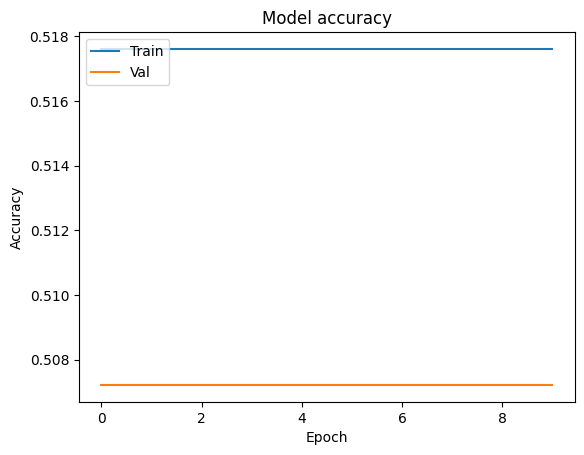

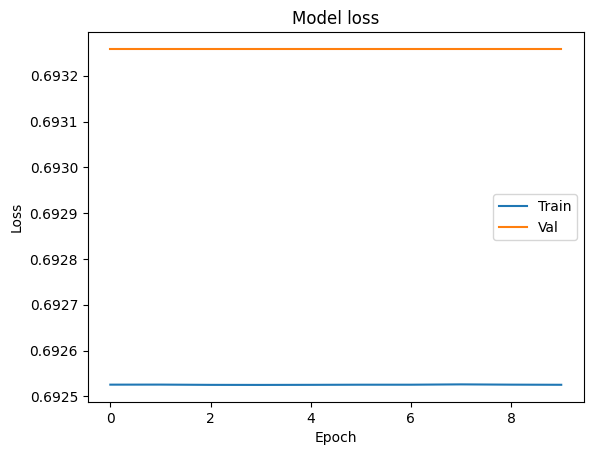

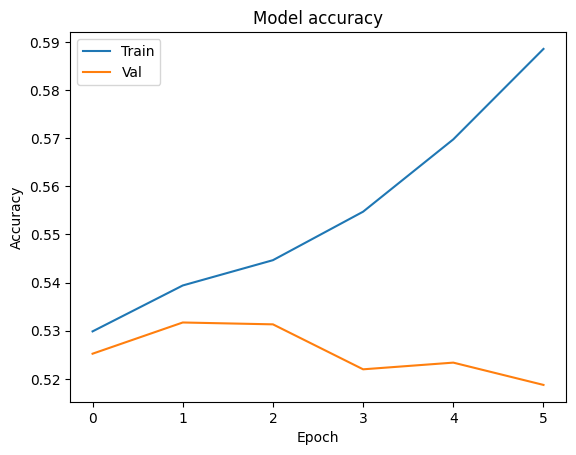

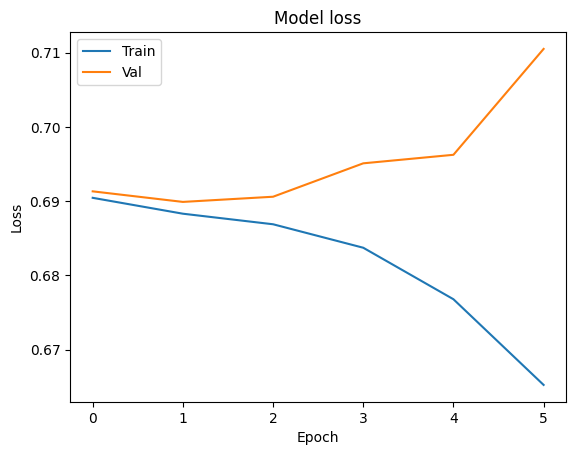

In [7]:
# trivial model for comparison
trivial_model = TrivialModel()
trivial_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# this model is not trainable, but we can still fit it to get the history for plotting
trivial_hist = trivial_model.fit(train_x_1hot, train_y, epochs=10, batch_size=256, validation_data=(val_x_1hot, val_y))

# train baseline model

base_model = BaselineModel()
base_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_hist = base_model.fit(train_x_1hot, train_y, epochs=6, batch_size=32, validation_data=(val_x_1hot, val_y))

# plot the results
stats.plot_history(trivial_hist)
stats.plot_history(base_hist)

As we can see, the baseline model does manage to get a higher accuracy than the average win rate. The validation accuracy starts going down really quickly, while the training accuracy keeps going up. This indicates that the model is overfitting to the training data. This is not surprising, since the model is very simple and the training data is very large. We will have to use a more complex model and try to use some regularization to prevent overfitting.


## Cleaned Data
Now we are going to check if using the cleaned data improves the performance of the model. To do that, we are simply going to train the model with the cleaned data and use the same val data as before. We will then compare the results to see if there is any improvement.

Epoch 1/6
6397/6397 [==============================] - 15s 2ms/step - loss: 0.6906 - accuracy: 0.5298 - val_loss: 0.6906 - val_accuracy: 0.5283
Epoch 2/6
6397/6397 [==============================] - 14s 2ms/step - loss: 0.6882 - accuracy: 0.5409 - val_loss: 0.6910 - val_accuracy: 0.5324
Epoch 3/6
6397/6397 [==============================] - 14s 2ms/step - loss: 0.6869 - accuracy: 0.5441 - val_loss: 0.6917 - val_accuracy: 0.5318
Epoch 4/6
6397/6397 [==============================] - 14s 2ms/step - loss: 0.6837 - accuracy: 0.5551 - val_loss: 0.6921 - val_accuracy: 0.5285
Epoch 5/6
6397/6397 [==============================] - 14s 2ms/step - loss: 0.6763 - accuracy: 0.5719 - val_loss: 0.6967 - val_accuracy: 0.5210
Epoch 6/6
6397/6397 [==============================] - 14s 2ms/step - loss: 0.6630 - accuracy: 0.5946 - val_loss: 0.7158 - val_accuracy: 0.5062


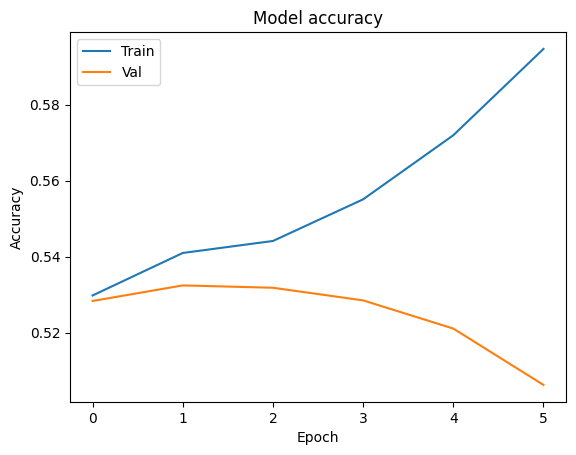

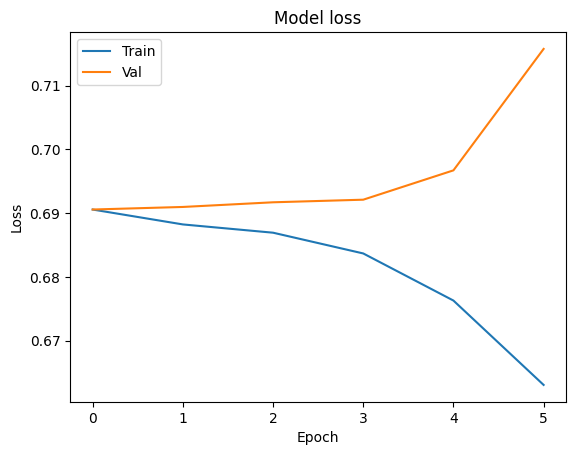

In [8]:
# same model, but with some matches filtered out
base_model_filtered = BaselineModel()
base_model_filtered.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

bmf_hist = base_model_filtered.fit(train_filtered_x_1hot, train_filtered_y, epochs=6, batch_size=32, validation_data=(val_x_1hot, val_y))

# plot the results
stats.plot_history(bmf_hist)

We can see that our validation accuracy is slightly higher at almost 0.54 and that the overfitting is a bit weaker, although it is still quite a lot. We can also observe, that the training accuracy is increasing faster than before. This is probably due to the fact that the filtered data contains less noise, so fewer games that are not as dependent on the champions as the average, which means that it is easier to learn the impact of each champion.

## Embeddings
Instead of using one-hot encoded vectors, we want to use an embedding layer. This is not only more convenient and easier to work with, it could also help to improve the models' performance as well as the training speed.

After the embedding layer, this model should be the same as the Baseline model, so we expect similar performance.

In [9]:
# a basic model that uses embeddings at the first layer instead of one hot vectors
class BasicEmbedding(tf.keras.Model):
    def __init__(self, champ_num=170, embed_dim=32):
        super(BasicEmbedding, self).__init__()
        self.champ_num = champ_num
        self.embed_dim = embed_dim
        player_num = 10
        self.embedding = tf.keras.layers.Embedding(champ_num, embed_dim, input_length=player_num)
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.dense4 = tf.keras.layers.Dense(128, activation='relu')
        self.dense5 = tf.keras.layers.Dense(1, activation='sigmoid')


    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.flatten(x)
        x = self.dense2(x)
        x = self.dense4(x)
        return self.dense5(x)

Epoch 1/6


6397/6397 [==============================] - 19s 3ms/step - loss: 0.6904 - accuracy: 0.5292 - val_loss: 0.6905 - val_accuracy: 0.5280
Epoch 2/6
6397/6397 [==============================] - 17s 3ms/step - loss: 0.6885 - accuracy: 0.5393 - val_loss: 0.6906 - val_accuracy: 0.5281
Epoch 3/6
6397/6397 [==============================] - 17s 3ms/step - loss: 0.6871 - accuracy: 0.5434 - val_loss: 0.6910 - val_accuracy: 0.5307
Epoch 4/6
6397/6397 [==============================] - 17s 3ms/step - loss: 0.6846 - accuracy: 0.5521 - val_loss: 0.6930 - val_accuracy: 0.5319
Epoch 5/6
6397/6397 [==============================] - 17s 3ms/step - loss: 0.6788 - accuracy: 0.5651 - val_loss: 0.6955 - val_accuracy: 0.5311
Epoch 6/6
6397/6397 [==============================] - 17s 3ms/step - loss: 0.6681 - accuracy: 0.5840 - val_loss: 0.7040 - val_accuracy: 0.5231


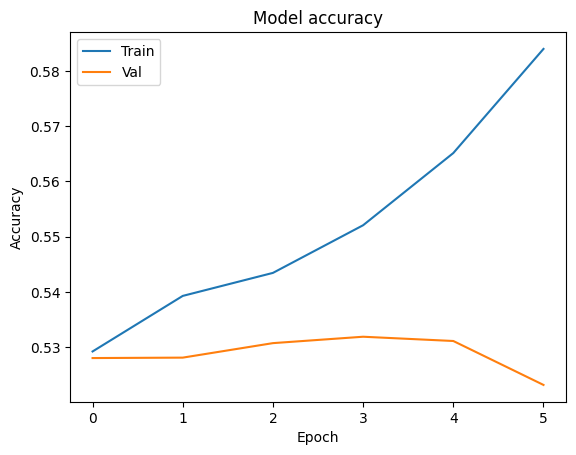

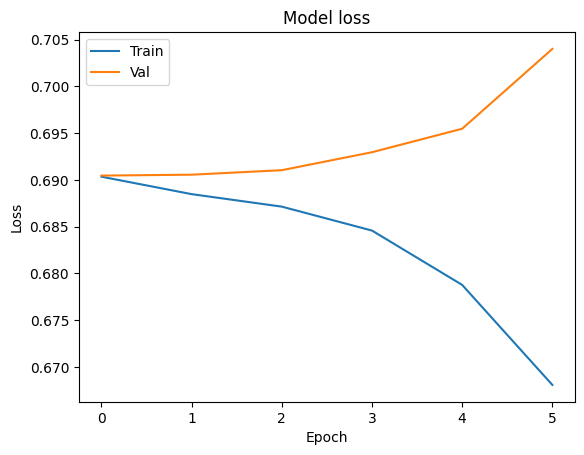

In [10]:
basic_embedding = BasicEmbedding()
basic_embedding.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

be_hist = basic_embedding.fit(train_filtered_x, train_filtered_y, epochs=6, batch_size=32, validation_data=(val_x, val_y))

# plot the results
stats.plot_history(be_hist)

We can see that this model is quite similar to the baseline version. We still have the overfitting problem and get a validation accuracy of slightly below 0.54. In the next step, we will try to use some data augmentation to improve the performance of our model and reduce overfitting.

## Data Augmentation
To reduce overfitting, we are going to use some data augmentation. We will do this by randomly swapping the champions of the blue and red side. This will create new training data that is similar to the original data, but not exactly the same. This should help to reduce overfitting and improve the performance of our model.

Since one of our goals is to predict the win chance during champion select and calculate the optimal pick for a given state, we will also introduce masking to our input data, which will allow us to hide the champions that have not been picked yet. Since the order in which champions are selected is more or less random anyway, masking the selection and keeping the outcome of the game should still result in one of all possible combinations during champion select. If we do this often enough, the model hopefully learns how champions interact with each other and which champions are good against others.

Lastly, we will randomly replace some champions with a random champion. This is basically introducing some noise to the data, which should help to reduce overfitting and improve the performance of our model. In addition, this will effectively increase the size of our training data, which should also help to reduce overfitting.


Epoch 1/20
3198/3198 [==============================] - 13s 4ms/step - loss: 0.6918 - accuracy: 0.5220 - val_loss: 0.6905 - val_accuracy: 0.5285
Epoch 2/20
3198/3198 [==============================] - 11s 4ms/step - loss: 0.6910 - accuracy: 0.5265 - val_loss: 0.6910 - val_accuracy: 0.5303
Epoch 3/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6909 - accuracy: 0.5273 - val_loss: 0.6913 - val_accuracy: 0.5247
Epoch 4/20
3198/3198 [==============================] - 11s 4ms/step - loss: 0.6906 - accuracy: 0.5303 - val_loss: 0.6912 - val_accuracy: 0.5265
Epoch 5/20
3198/3198 [==============================] - 11s 4ms/step - loss: 0.6906 - accuracy: 0.5286 - val_loss: 0.6911 - val_accuracy: 0.5271
Epoch 6/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6906 - accuracy: 0.5287 - val_loss: 0.6910 - val_accuracy: 0.5302
Epoch 7/20
3198/3198 [==============================] - 11s 4ms/step - loss: 0.6904 - accuracy: 0.5288 - val_loss: 0.6916 - val_ac

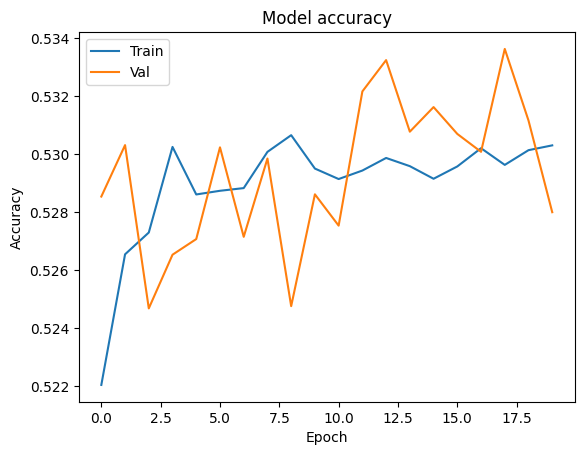

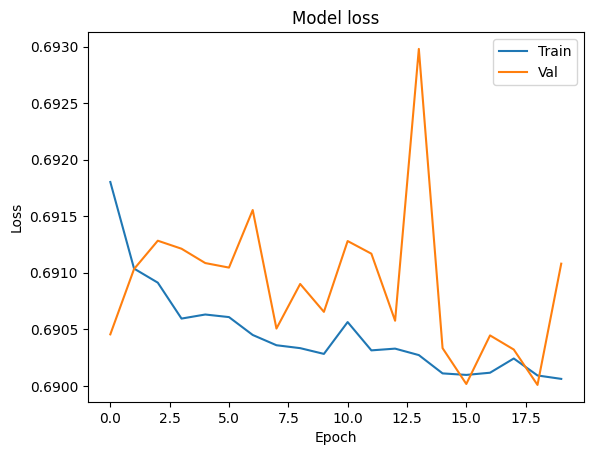

In [11]:

import augmentation # for data augmentation
# see augmentation.py for more info

# aug_chance is the chance that a match will be augmented
# max_replace is the maximum number of champions that can be replaced
# batch_size is the batch size used for training
aug = augmentation.MatchAugmentation(train_filtered_x, train_filtered_y, aug_chance=0.90, batch_size=64, max_replace=3)

aug_emb = BasicEmbedding()
aug_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

aug_hist = aug_emb.fit(aug, epochs=20, validation_data=(val_x, val_y))

# plot the results
stats.plot_history(aug_hist)

These first test show that the augmentation prevents the model from overfitting. The accuracy is not higher than before, but we can see that it keeps improving even after 20 epochs, when it started going down before. This means that we could probably train the model for longer and get a higher accuracy, but the downside is that the training will take longer.

We will now try some other parameters for the augmentation and see if we can improve the performance of our model. It is possible that we introduced too much noise, which could be the reason why the accuracy is not higher than before.

Epoch 1/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6918 - accuracy: 0.5212 - val_loss: 0.6911 - val_accuracy: 0.5275
Epoch 2/20
3198/3198 [==============================] - 11s 4ms/step - loss: 0.6909 - accuracy: 0.5273 - val_loss: 0.6908 - val_accuracy: 0.5278
Epoch 3/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6905 - accuracy: 0.5286 - val_loss: 0.6906 - val_accuracy: 0.5265
Epoch 4/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6904 - accuracy: 0.5295 - val_loss: 0.6916 - val_accuracy: 0.5279
Epoch 5/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6901 - accuracy: 0.5300 - val_loss: 0.6910 - val_accuracy: 0.5265
Epoch 6/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6899 - accuracy: 0.5312 - val_loss: 0.6903 - val_accuracy: 0.5312
Epoch 7/20
3198/3198 [==============================] - 11s 3ms/step - loss: 0.6901 - accuracy: 0.5319 - val_loss: 0.6905 - val_ac

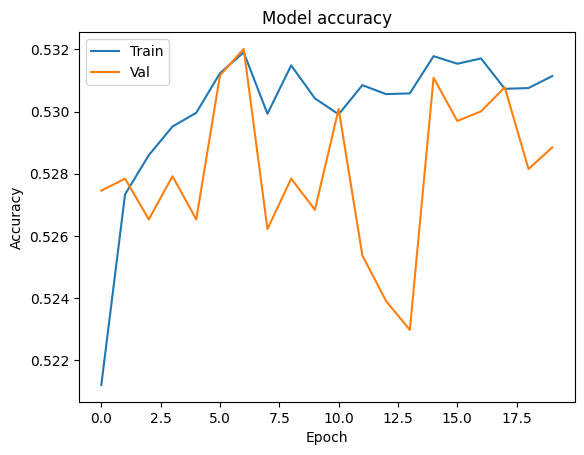

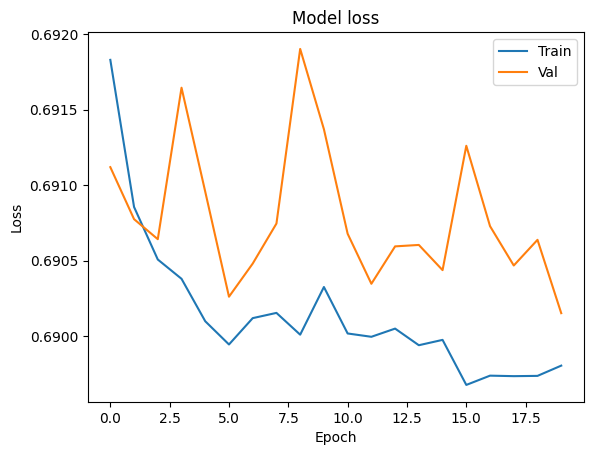

In [12]:

# lower chance of augmentation
# lower max_replace
aug2 = augmentation.MatchAugmentation(train_filtered_x, train_filtered_y, aug_chance=0.85, batch_size=64, max_replace=2)

aug_emb2 = BasicEmbedding()
aug_emb2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

aug_hist2 = aug_emb2.fit(aug2, epochs=20, validation_data=(val_x, val_y))

# plot the results
stats.plot_history(aug_hist2)

We tested a few different parameters, but it seemed like the best results were achieved with the following parameters:
- aug_chance: 0.85
- max_replace: 2
- batch_size: 64

This does not necessarily mean that these are also the best parameters for different models, but we will use them as default values for now and see if we can improve then later.

Evaluating  Avg chance
  1/405 [..............................] - ETA: 25s - loss: 0.6938 - accuracy: 0.5000

405/405 [==============================] - 1s 1ms/step - loss: 0.6926 - accuracy: 0.5173
Test accuracy:  0.6925509572029114
Test loss:  0.5172626972198486
Evaluating  Basic Emb.
405/405 [==============================] - 1s 2ms/step - loss: 0.7082 - accuracy: 0.5174
Test accuracy:  0.7081529498100281
Test loss:  0.5174171328544617
Evaluating  Augm. Emb.
405/405 [==============================] - 1s 2ms/step - loss: 0.6898 - accuracy: 0.5313
Test accuracy:  0.6898033618927002
Test loss:  0.5313199758529663


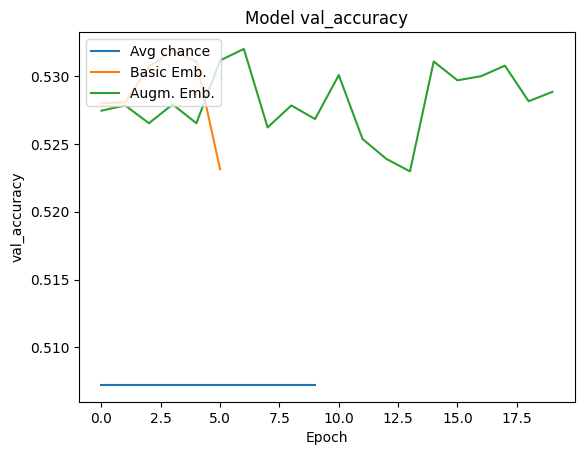

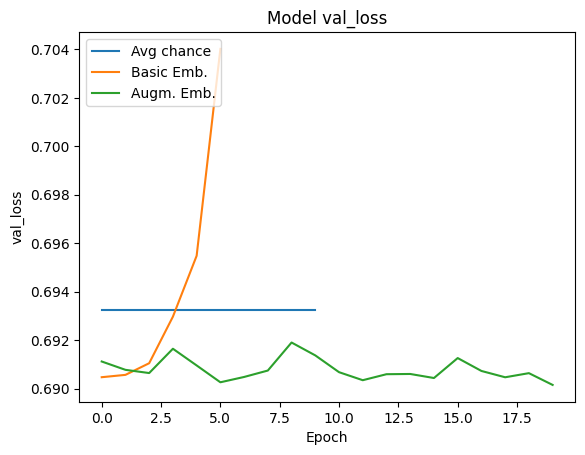

In [13]:
import stats
# this module has a few functions and classes that make plotting and comparing performance easier
# see stats.py for more details

comparator = stats.ModelComparator((test_x, test_y))

comparator.add_model(trivial_model, trivial_hist, "Avg chance")
comparator.add_model(basic_embedding, be_hist, "Basic Emb.")
comparator.add_model(aug_emb2, aug_hist2, "Augm. Emb.")

comparator.plot_histories()

In the graphs above, we can see how the embedding model with augmentation performs clearly the best and does not suffer from overfitting. In the next steps we will try to create more complex models and hopefully improve the performance further.

## Different Architectures
In this section, we will try to use different architectures and measure their performance.

The first one is still similar to the BasicEmbedding model, since it starts with an embedding layers followed by a few dense layers. The difference hear is the number of layers, which, depending on the parameters, will be a lot higher, and the residual connections to make training this deeper model easier.

We will also adjust the learning parameters and try out which of them work the best.

In [14]:
# training parameters
aug = augmentation.MatchAugmentation(train_filtered_x, train_filtered_y, aug_chance=0.90, batch_size=64, max_replace=2)

# adapts learning rate and batch size based on epoch
def create_scheduler(lr_f, bs_f, min_lr=1e-10, max_lr=1e-3, min_bs=4, max_bs=256, aug=aug):
    def schedul_f(epoch):
      bs = bs_f(epoch)
      bs = max(bs, min_bs)
      bs = min(bs, max_bs)

      # adjust batch size in augmentor
      # doesnt work yet :(
      #aug.batch_size = bs

      lr = lr_f(epoch)
      lr = max(lr, min_lr)
      lr = min(lr, max_lr)

      return lr

    scheduler = tf.keras.callbacks.LearningRateScheduler(schedul_f)
    return scheduler


In [15]:
# Deep Embedding

# a deep embedding model with multiple layers consisting of dense layers and residual connections and layer norm
class DeepEmbedding(tf.keras.Model):
    def __init__(self, champ_num=170, embed_dim=32, n_layers=4, layer_size=3):
        super(DeepEmbedding, self).__init__()
        self.champ_num = champ_num
        self.embed_dim = embed_dim
        self.n_layers=n_layers
        self.layer_size=layer_size
        player_num = 10
        self.embedding = tf.keras.layers.Embedding(champ_num, embed_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.layer_norm = tf.keras.layers.LayerNormalization()


        self.deep_layers = []
        for _ in range(n_layers):
            l = []
            for _ in range(layer_size):
                l.append(
                    tf.keras.layers.Dense(player_num*embed_dim, activation='gelu')
                )
            self.deep_layers.append(l)

            

        self.dense_output1 = tf.keras.layers.Dense(embed_dim*5, activation='gelu')
        self.dense_output2 = tf.keras.layers.Dense(embed_dim*2, activation='gelu')
        self.dense_output3 = tf.keras.layers.Dense(1, activation='sigmoid')


    def call(self, inputs):
        x0 = self.embedding(inputs)
        x0 = self.flatten(x0)

        for i in range(self.n_layers):
            x = self.deep_layers[i][0](x0)
            for j in range(1, self.layer_size):
                x = self.deep_layers[i][j](x)
                
            x += x0
            x0 = self.layer_norm(x)
        
        x = self.dense_output1(x0)
        x = self.dense_output2(x)
        return self.dense_output3(x)

In [16]:

deep_emb_model = DeepEmbedding(n_layers=4, layer_size=3)
deep_emb_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

scheduler = create_scheduler(lambda epoch: 0.0001 * 0.97**epoch, lambda epoch: 8*(2**(epoch//5)))
deep_emb_hist = deep_emb_model.fit(aug, epochs=10, validation_data=(val_x, val_y), callbacks=[scheduler])

Epoch 1/10
3198/3198 [==============================] - 32s 9ms/step - loss: 0.6958 - accuracy: 0.5067 - val_loss: 0.6935 - val_accuracy: 0.5110 - lr: 1.0000e-04
Epoch 2/10
3198/3198 [==============================] - 28s 9ms/step - loss: 0.6927 - accuracy: 0.5131 - val_loss: 0.6918 - val_accuracy: 0.5227 - lr: 9.7000e-05
Epoch 3/10
3198/3198 [==============================] - 28s 9ms/step - loss: 0.6914 - accuracy: 0.5230 - val_loss: 0.6909 - val_accuracy: 0.5302 - lr: 9.4090e-05
Epoch 4/10
3198/3198 [==============================] - 28s 9ms/step - loss: 0.6908 - accuracy: 0.5260 - val_loss: 0.6920 - val_accuracy: 0.5247 - lr: 9.1267e-05
Epoch 5/10
3198/3198 [==============================] - 28s 9ms/step - loss: 0.6906 - accuracy: 0.5287 - val_loss: 0.6908 - val_accuracy: 0.5335 - lr: 8.8529e-05
Epoch 6/10
3198/3198 [==============================] - 28s 9ms/step - loss: 0.6906 - accuracy: 0.5299 - val_loss: 0.6910 - val_accuracy: 0.5271 - lr: 8.5873e-05
Epoch 7/10
3198/3198 [======

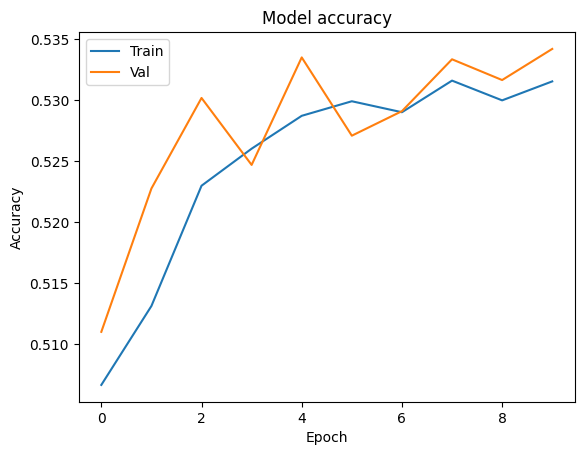

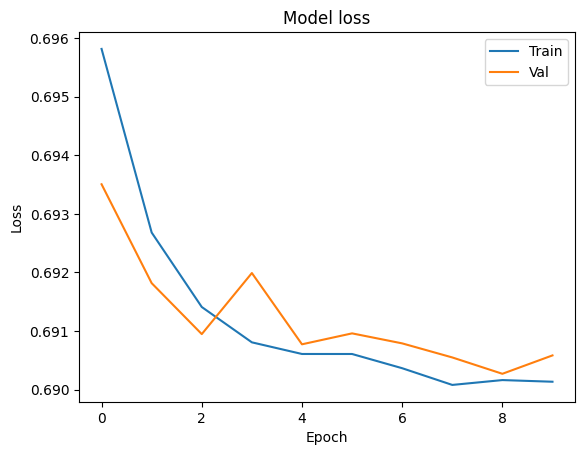

In [17]:

stats.plot_history(deep_emb_hist)

The smaller version of the DeepEmbedding model performed relatively well and kept steadily increasing during training, so we will try to train a version with a few more layers to see if this can improve the performance further.

In [24]:
aug = augmentation.MatchAugmentation(train_filtered_x, train_filtered_y, aug_chance=0.95, batch_size=32, max_replace=2)

deeper_emb_model = DeepEmbedding(n_layers=10, layer_size=5)
deeper_emb_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

scheduler = create_scheduler(lambda epoch: 0.0001 * 0.90**epoch, lambda epoch: 8*(2**(epoch//5)))
deeper_emb_hist = deeper_emb_model.fit(aug, epochs=30, validation_data=(val_x, val_y), callbacks=[scheduler])

Epoch 1/30
6397/6397 [==============================] - 63s 10ms/step - loss: 0.6893 - accuracy: 0.5336 - val_loss: 0.6910 - val_accuracy: 0.5232 - lr: 1.0000e-04
Epoch 2/30
6397/6397 [==============================] - 59s 9ms/step - loss: 0.6893 - accuracy: 0.5336 - val_loss: 0.6905 - val_accuracy: 0.5305 - lr: 9.0000e-05
Epoch 3/30
6397/6397 [==============================] - 60s 9ms/step - loss: 0.6892 - accuracy: 0.5342 - val_loss: 0.6913 - val_accuracy: 0.5301 - lr: 8.1000e-05
Epoch 4/30
6397/6397 [==============================] - 54s 8ms/step - loss: 0.6892 - accuracy: 0.5337 - val_loss: 0.6905 - val_accuracy: 0.5267 - lr: 7.2900e-05
Epoch 5/30
6397/6397 [==============================] - 49s 8ms/step - loss: 0.6892 - accuracy: 0.5348 - val_loss: 0.6909 - val_accuracy: 0.5271 - lr: 6.5610e-05
Epoch 6/30
6397/6397 [==============================] - 48s 8ms/step - loss: 0.6889 - accuracy: 0.5353 - val_loss: 0.6921 - val_accuracy: 0.5250 - lr: 5.9049e-05
Epoch 7/30
6397/6397 [=====

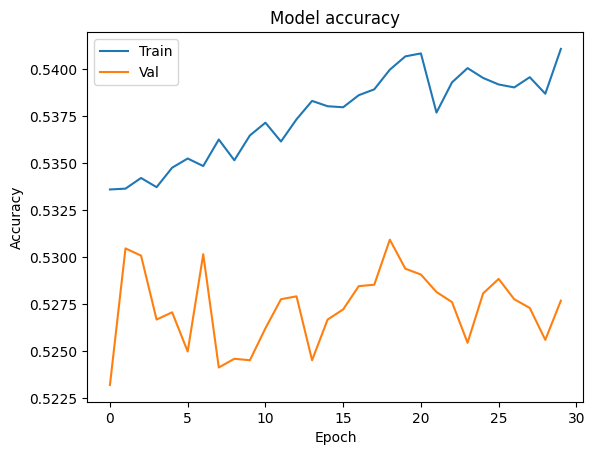

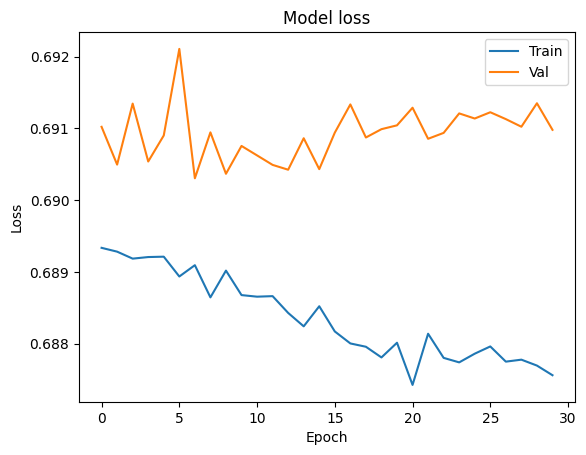

In [25]:
stats.plot_history(deeper_emb_hist)

We've tested a few different hyperparameters like learning rates, batch sizes, epochs, number of layers and layer sizes, but overall the model just starts to overfit more compared to the smaller one. We will move on for now and test different architectures that are more specialized to the specific task, instead of just using a bunch of dense layers.

## Convolution Model
This model consists of a set amount of layers that are stacked after another. In contrast to the previous model, this model tries to compare the individual inputs, the 10 different champions, to each other instead of just processing everything at once with dense layers. To do this, we are using a conv1d layer after a simple linear layer to hopefully learn more general relationships.

In addition, this model uses two embedding layers instead of one. As before, the first one is for the champions, but the second one is for the team, which is 0 for when the champion index is 0, 1 for the blue side and 2 for the red side.
These embeddings get added to one tensor and then passed through the layer. The idea behind this is that the relationship between champions depends on if they are on the same or on different teams, and with this technique the model could learn to treat them differently, while still being based on the same champion. The dense models before didn't have this requirement, since every layer was densely connected with the previous one, which means that the order of the embeddings also included the team.

In [26]:
# a model with multiple layers that consist of conv1d, max pool, dense layers and residual connections
class DeepConv(tf.keras.Model):
    def __init__(self, champ_num=170, emb_dim=32, n_layers=3):
        super().__init__()
        player_num = 10
        self.n_layers = n_layers
        self.player_num = player_num
        self.champ_num = champ_num
        self.emb_dim = emb_dim
        self.embedding = tf.keras.layers.Embedding(champ_num, emb_dim, input_length=player_num)
        #self.expand = tf.keras.layers.Dense(emb_dim*player_num, activation=None)
        self.team_embedding = tf.keras.layers.Embedding(3, emb_dim, input_length=player_num)
        self.deep_layers = []
        self.layer_norm = tf.keras.layers.LayerNormalization()
        for i in range(n_layers):
            layer = []
            lname = "_layer_" + str(i)
            tf.keras.layers.Reshape((-1, player_num*emb_dim))
            layer.append(tf.keras.layers.Dense(emb_dim*player_num*player_num, activation=None, name="expand"+lname))
            tf.keras.layers.Reshape((-1, player_num*emb_dim, player_num))
            layer.append(tf.keras.layers.Conv1D(emb_dim, 5, strides=5, padding="same", activation='gelu', name="conv1d"+lname))
            self.clayers.append(tf.keras.layers.MaxPool1D(2, name="maxpool"+lname))
            
            layer.append(tf.keras.layers.Dense(emb_dim, activation='gelu', name="dense"+lname))
            

        #self.maxpool = tf.keras.layers.MaxPool1D(10)
        self.flatten = tf.keras.layers.Flatten()


        self.dense1 = tf.keras.layers.Dense(emb_dim*6, activation='gelu')
        self.dense2 = tf.keras.layers.Dense(emb_dim*3, activation='gelu')
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')





    def call(self, inputs):
        # mask for empty slots
        mask = tf.where(inputs == 0, 0, 1)
        x = self.embedding(inputs)

        # team embedding
        team_vals = [1,1,1,1,1,2,2,2,2,2]
        team_vals = tf.convert_to_tensor(team_vals)
        team_vals = tf.reshape(team_vals, (-1, 10))
        team_vals = team_vals * mask
        team_vals = tf.cast(team_vals, tf.int32)
        team_vals = self.team_embedding(team_vals)

        # add team embedding to champion embedding
        x = x + team_vals

        for layer in self.deep_layers:
            xl = layer[0](x)
            for i in range(1, len(layer)):
                xl = layer[i](xl)

            # residual connection
            x+=xl
            x = self.layer_norm(x)


        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [ ]:
aug = augmentation.MatchAugmentation(train_filtered_x, train_filtered_y, aug_chance=0.95, batch_size=32, max_replace=2)

deep_conv_model = DeepConv()
deep_conv_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

scheduler = create_scheduler(lambda epoch: 0.0001 * 0.90**epoch, lambda epoch: 8*(2**(epoch//5)))
deeper_conv_hist = deep_conv_model.fit(aug, epochs=30, validation_data=(val_x, val_y), callbacks=[scheduler])